# Hyperparameter Optimization Comparison: Breast Cancer Dataset

This notebook provides a **reproducible comparison** of four hyperparameter optimization methods on a real-world medical dataset:

1. **Genetic Search** (mloptimizer) - Evolutionary algorithm with early stopping
2. **Grid Search** (sklearn) - Exhaustive search
3. **Random Search** (sklearn) - Random sampling
4. **Bayesian Optimization** (hyperopt) - Sequential model-based optimization

## Dataset: Breast Cancer Wisconsin (Diagnostic)

- **Samples**: 569
- **Features**: 30 continuous features
- **Task**: Binary classification (Malignant vs Benign)
- **Challenge**: Class imbalance (37.3% / 62.7%)
- **Estimator**: XGBoost Classifier
- **Metric**: Balanced Accuracy (accounts for class imbalance)

## Reproducibility

All random seeds are **fixed at 42** for complete reproducibility.

## 1. Setup and Imports

In [1]:
# Standard library
import warnings
from time import time

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

# Hyperparameter optimization
from mloptimizer.domain.hyperspace import HyperparameterSpace, Hyperparam
from mloptimizer.interfaces import GeneticSearch
from mloptimizer.application.reporting.plots import (
    plotly_search_space, plotly_logbook,
    plot_search_space, plot_logbook
)
from hyperopt import hp as hyperopt_hp, tpe, fmin, Trials, STATUS_OK

# Configure
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("All libraries imported successfully")
print(f"Random seed fixed at: {RANDOM_SEED}")

All libraries imported successfully
Random seed fixed at: 42


/home/paradox/workspace/mloptimizer/.uvenv/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Create figures directory for outputs
import os
os.makedirs('figures', exist_ok=True)
print("Figures directory created/verified: figures/")

Figures directory created/verified: figures/


## 2. Load and Explore Dataset

In [3]:
# Load Breast Cancer Wisconsin dataset
X, y = load_breast_cancer(return_X_y=True)

print("=" * 80)
print("BREAST CANCER WISCONSIN DATASET")
print("=" * 80)
print(f"\nDataset Characteristics:")
print(f"   - Samples: {X.shape[0]}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Classes: {len(np.unique(y))}")
print(f"\nClass Distribution:")
print(f"   - Benign (0): {np.sum(y==0)} ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"   - Malignant (1): {np.sum(y==1)} ({100*np.sum(y==1)/len(y):.1f}%)")
print(f"\nClass Imbalance Ratio: {max(np.sum(y==0), np.sum(y==1)) / min(np.sum(y==0), np.sum(y==1)):.2f}:1")

BREAST CANCER WISCONSIN DATASET

Dataset Characteristics:
   - Samples: 569
   - Features: 30
   - Classes: 2

Class Distribution:
   - Benign (0): 212 (37.3%)
   - Malignant (1): 357 (62.7%)

Class Imbalance Ratio: 1.68:1


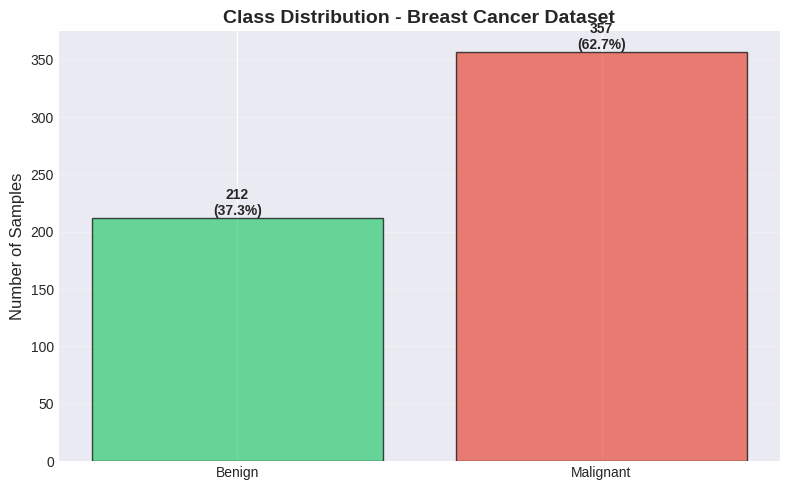

In [4]:
# Visualize class distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
classes, counts = np.unique(y, return_counts=True)
colors = ['#2ecc71', '#e74c3c']
ax.bar(['Benign', 'Malignant'], counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Class Distribution - Breast Cancer Dataset', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, (c, count) in enumerate(zip(['Benign', 'Malignant'], counts)):
    ax.text(i, count, f'{count}\n({100*count/len(y):.1f}%)', 
            ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Experimental Setup

### Cross-Validation Strategy
- **Method**: 5-fold Stratified K-Fold
- **Why**: Maintains class distribution in each fold
- **Seed**: Fixed at 42 for reproducibility

### Hyperparameter Search Space
We optimize 6 XGBoost hyperparameters:

In [5]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Define hyperparameter search space for Genetic Search
# Note: Hyperparam uses internal integer representation with scale for floats
fixed_hyperparams = {}
evolvable_hyperparams = {
    'colsample_bytree': Hyperparam('colsample_bytree', 3, 10, 'float', 10),  # [0.3, 1.0]
    'gamma': Hyperparam('gamma', 0, 20, 'int'),                               # [0, 20]
    'learning_rate': Hyperparam('learning_rate', 1, 100, 'float', 1000),      # [0.001, 0.1]
    'max_depth': Hyperparam('max_depth', 2, 20, 'int'),                       # [2, 20]
    'n_estimators': Hyperparam('n_estimators', 100, 500, 'int'),              # [100, 500]
    'subsample': Hyperparam('subsample', 700, 1000, 'float', 1000)            # [0.7, 1.0]
}

# Display search space with actual ranges
print("=" * 70)
print("HYPERPARAMETER SEARCH SPACE (Common across all methods)")
print("=" * 70)
search_space_info = []
for name, param in evolvable_hyperparams.items():
    if param.hyperparam_type == 'float':
        min_val = param.min_value / param.scale
        max_val = param.max_value / param.scale
        print(f"  {name:20s}: [{min_val:.3f}, {max_val:.3f}] (continuous)")
        search_space_info.append({'param': name, 'min': min_val, 'max': max_val, 'type': 'float'})
    else:
        print(f"  {name:20s}: [{param.min_value}, {param.max_value}] (integer)")
        search_space_info.append({'param': name, 'min': param.min_value, 'max': param.max_value, 'type': 'int'})
print("=" * 70)

HYPERPARAMETER SEARCH SPACE (Common across all methods)
  colsample_bytree    : [0.300, 1.000] (continuous)
  gamma               : [0, 20] (integer)
  learning_rate       : [0.001, 0.100] (continuous)
  max_depth           : [2, 20] (integer)
  n_estimators        : [100, 500] (integer)
  subsample           : [0.700, 1.000] (continuous)


## 4. Method 1: Genetic Search (mloptimizer)

### Configuration (Fair Comparison: ~110 evaluations)
- **Population size**: 20 individuals
- **Generations**: 7
- **Elites**: 2 (10% - preserved without re-evaluation)
- **Crossover probability**: 0.7
- **Mutation probability**: 0.4
- **Parallelization**: Enabled

In [6]:
# Create hyperparameter space
hyperparameter_space = HyperparameterSpace(fixed_hyperparams, evolvable_hyperparams)

# Configure Genetic Search - ~200 evaluations budget
genetic_params = {
    'generations': 11,
    'population_size': 20,
    'n_elites': 1,
    'tournsize': 2,
    'cxpb': 0.5,
    'mutpb': 0.6,
    'indpb': 0.3,
    'early_stopping': False,
    'seed': RANDOM_SEED,
    'use_parallel': True
}

opt_genetic = GeneticSearch(
    estimator_class=XGBClassifier,
    hyperparam_space=hyperparameter_space,
    cv=cv,
    scoring="balanced_accuracy",
    disable_file_output=True,
    **genetic_params
)

print("Genetic Search configured:")
print(f"   Target: ~200 evaluations")
print(f"   Population: {genetic_params['population_size']}, Generations: {genetic_params['generations']}")

Genetic Search configured:
   Target: ~200 evaluations
   Population: 20, Generations: 11


In [7]:
# Run Genetic Search
print("Starting Genetic Search optimization...\n")
opt_genetic.fit(X, y)

# Extract results using proper attributes
population_df = opt_genetic.populations_
best_score_genetic = float(population_df.sort_values(by="fitness", ascending=False)['fitness'].iloc[0])
best_params_genetic = opt_genetic.best_params_
n_evals_genetic = opt_genetic.n_trials_
time_genetic = opt_genetic.optimization_time_

print("\n" + "=" * 80)
print("GENETIC SEARCH COMPLETE")
print("=" * 80)
print(f"   Best Balanced Accuracy: {best_score_genetic:.4f}")
print(f"   Actual Evaluations: {n_evals_genetic}")
print(f"   Optimization Time: {time_genetic:.2f}s")
print(f"\nEvolution Statistics:")
for record in opt_genetic.logbook_:
    print(f"   Gen {record['gen']}: Best={record['max']:.4f}, Avg={record['avg']:.4f}, Evals={record['nevals']}")

Starting Genetic Search optimization...


GENETIC SEARCH COMPLETE
   Best Balanced Accuracy: 0.9690
   Actual Evaluations: 196
   Optimization Time: 30.95s

Evolution Statistics:
   Gen 0: Best=0.9606, Avg=0.9428, Evals=20
   Gen 1: Best=0.9610, Avg=0.9481, Evals=16
   Gen 2: Best=0.9648, Avg=0.9300, Evals=16
   Gen 3: Best=0.9648, Avg=0.9331, Evals=16
   Gen 4: Best=0.9648, Avg=0.9547, Evals=16
   Gen 5: Best=0.9690, Avg=0.9593, Evals=16
   Gen 6: Best=0.9690, Avg=0.9599, Evals=16
   Gen 7: Best=0.9690, Avg=0.9590, Evals=16
   Gen 8: Best=0.9690, Avg=0.9591, Evals=16
   Gen 9: Best=0.9690, Avg=0.9595, Evals=16
   Gen 10: Best=0.9690, Avg=0.9609, Evals=16
   Gen 11: Best=0.9690, Avg=0.9593, Evals=16


In [8]:
# Display best hyperparameters found
print("Best Hyperparameters (Genetic Search):")
print("=" * 60)
for key in evolvable_hyperparams.keys():
    print(f"   - {key:20s}: {best_params_genetic.get(key, 'N/A')}")

Best Hyperparameters (Genetic Search):
   - colsample_bytree    : 0.6
   - gamma               : 0
   - learning_rate       : 0.094
   - max_depth           : 13
   - n_estimators        : 374
   - subsample           : 0.799


In [9]:
# Visualize search space exploration (interactive)
population_df_filtered = population_df[list(evolvable_hyperparams.keys()) + ['fitness']]
fig_space = plotly_search_space(population_df_filtered)
fig_space.update_layout(
    title="Genetic Search - Hyperparameter Space Exploration",
    height=800,
    width=800
)
fig_space.show()

# Save figure
fig_space.write_image('figures/search_space_plotly.png', scale=2)

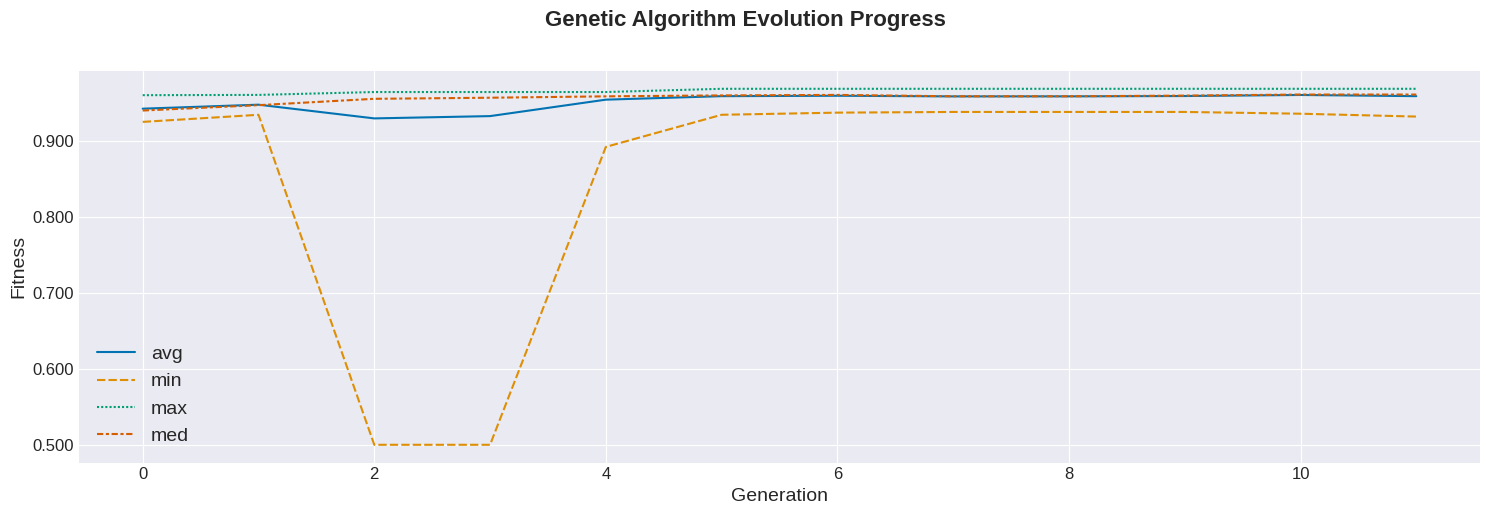

In [10]:
# Evolution plot using mloptimizer's plot_logbook
fig_evolution = plot_logbook(opt_genetic.logbook_, font_size=14)
fig_evolution.suptitle('Genetic Algorithm Evolution Progress', fontsize=16, fontweight='bold', y=1.02)
fig_evolution.set_size_inches(15, 5)
plt.tight_layout()
fig_evolution.savefig('figures/evolution_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Method 2: Grid Search (sklearn)

### Configuration
- **Grid size**: 2^6 = 64 configurations
- **Strategy**: Exhaustive search over discrete grid
- **Parallelization**: Sequential (n_jobs=1) for fair comparison

In [11]:
# Define grid parameters - ~200 evaluations
# 3^3 * 2^3 = 27 * 8 = 216 configurations
grid_parameters = {
    'colsample_bytree': (0.3, 0.65, 1.0),       # 3 points
    'gamma': (0, 10, 20),                        # 3 points
    'learning_rate': (0.001, 0.05, 0.1),         # 3 points
    'max_depth': (2, 20),                        # 2 points
    'n_estimators': (100, 500),                  # 2 points
    'subsample': (0.7, 1.0)                      # 2 points
}

xgb = XGBClassifier(random_state=RANDOM_SEED)
grid_search = GridSearchCV(
    xgb,
    grid_parameters,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=1,
    verbose=1
)

n_grid_configs = 1
for v in grid_parameters.values():
    n_grid_configs *= len(v)
    
print(f"Grid Search configured: {n_grid_configs} configurations")

Grid Search configured: 216 configurations


In [12]:
# Run Grid Search
print("Starting Grid Search optimization...\n")

t0_grid = time()
grid_search.fit(X, y)
t1_grid = time()
time_grid = t1_grid - t0_grid

# Extract results
best_score_grid = grid_search.best_score_
best_params_grid = grid_search.best_params_
n_evals_grid = len(grid_search.cv_results_['params'])

print("\n" + "=" * 80)
print("GRID SEARCH COMPLETE")
print("=" * 80)
print(f"   Best Balanced Accuracy: {best_score_grid:.4f}")
print(f"   Configurations Evaluated: {n_evals_grid}")
print(f"   Optimization Time: {time_grid:.2f}s")

Starting Grid Search optimization...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

GRID SEARCH COMPLETE
   Best Balanced Accuracy: 0.9666
   Configurations Evaluated: 216
   Optimization Time: 76.28s


In [13]:
# Display best hyperparameters
print("Best Hyperparameters (Grid Search):")
print("=" * 60)
for key, value in best_params_grid.items():
    print(f"   - {key:20s}: {value}")

Best Hyperparameters (Grid Search):
   - colsample_bytree    : 0.3
   - gamma               : 0
   - learning_rate       : 0.1
   - max_depth           : 2
   - n_estimators        : 500
   - subsample           : 0.7


## 6. Method 3: Random Search (sklearn)

### Configuration
- **Iterations**: 200
- **Strategy**: Random sampling from distributions
- **Parallelization**: Sequential (n_jobs=1) for fair comparison

In [14]:
# Define parameter distributions (aligned with genetic search space bounds)
random_distributions = {
    'colsample_bytree': uniform(loc=0.3, scale=0.7),     # [0.3, 1.0]
    'gamma': randint(low=0, high=21),                     # [0, 20] inclusive
    'learning_rate': uniform(loc=0.001, scale=0.099),     # [0.001, 0.1]
    'max_depth': randint(low=2, high=21),                 # [2, 20] inclusive
    'n_estimators': randint(low=100, high=501),           # [100, 500] inclusive
    'subsample': uniform(loc=0.7, scale=0.3)              # [0.7, 1.0]
}

random_search = RandomizedSearchCV(
    xgb,
    random_distributions,
    cv=cv,
    n_iter=200,  # ~200 evaluations
    random_state=RANDOM_SEED,
    scoring="balanced_accuracy",
    n_jobs=1,
    verbose=1
)

print("Random Search configured: 200 iterations")

Random Search configured: 200 iterations


In [15]:
# Run Random Search
print("Starting Random Search optimization...\n")

t0_random = time()
random_search.fit(X, y)
t1_random = time()
time_random = t1_random - t0_random

# Extract results
best_score_random = random_search.best_score_
best_params_random = random_search.best_params_
n_evals_random = len(random_search.cv_results_['params'])

print("\n" + "=" * 80)
print("RANDOM SEARCH COMPLETE")
print("=" * 80)
print(f"   Best Balanced Accuracy: {best_score_random:.4f}")
print(f"   Configurations Evaluated: {n_evals_random}")
print(f"   Optimization Time: {time_random:.2f}s")

Starting Random Search optimization...

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

RANDOM SEARCH COMPLETE
   Best Balanced Accuracy: 0.9639
   Configurations Evaluated: 200
   Optimization Time: 62.55s


In [16]:
# Display best hyperparameters
print("Best Hyperparameters (Random Search):")
print("=" * 60)
for key, value in best_params_random.items():
    print(f"   - {key:20s}: {value}")

Best Hyperparameters (Random Search):
   - colsample_bytree    : 0.711217522963852
   - gamma               : 0
   - learning_rate       : 0.07777723405280605
   - max_depth           : 16
   - n_estimators        : 293
   - subsample           : 0.860336767377174


## 7. Method 4: Bayesian Optimization (hyperopt)

### Configuration
- **Iterations**: 200
- **Algorithm**: Tree-structured Parzen Estimator (TPE)
- **Parallelization**: Sequential (n_jobs=1) for fair comparison

In [17]:
# Define hyperopt search space (aligned with genetic search space bounds)
bayesian_space = {
    'colsample_bytree': hyperopt_hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hyperopt_hp.choice('gamma', list(range(0, 21))),
    'learning_rate': hyperopt_hp.uniform('learning_rate', 0.001, 0.1),
    'max_depth': hyperopt_hp.choice('max_depth', list(range(2, 21))),
    'n_estimators': hyperopt_hp.choice('n_estimators', list(range(100, 501))),
    'subsample': hyperopt_hp.uniform('subsample', 0.7, 1.0)
}

def objective_function(params):
    """Objective function for Bayesian optimization."""
    clf = XGBClassifier(**params, random_state=RANDOM_SEED)
    score = cross_val_score(clf, X, y, cv=cv, scoring="balanced_accuracy", n_jobs=1).mean()
    return {'loss': -score, 'status': STATUS_OK}

print("Bayesian Optimization (TPE) configured: 200 evaluations")

Bayesian Optimization (TPE) configured: 200 evaluations


In [18]:
# Run Bayesian Optimization
print("Starting Bayesian Optimization...\n")

trials = Trials()

t0_bayes = time()
best_params_bayes = fmin(
    objective_function,
    bayesian_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials,
    verbose=0,
    rstate=np.random.default_rng(RANDOM_SEED)
)
t1_bayes = time()
time_bayes = t1_bayes - t0_bayes

# Extract results
scores_list = [-trial['result']['loss'] for trial in trials.trials]
best_score_bayes = max(scores_list)
n_evals_bayes = len(trials.trials)

print("\n" + "=" * 80)
print("BAYESIAN OPTIMIZATION COMPLETE")
print("=" * 80)
print(f"   Best Balanced Accuracy: {best_score_bayes:.4f}")
print(f"   Evaluations: {n_evals_bayes}")
print(f"   Optimization Time: {time_bayes:.2f}s")

Starting Bayesian Optimization...


BAYESIAN OPTIMIZATION COMPLETE
   Best Balanced Accuracy: 0.9704
   Evaluations: 200
   Optimization Time: 65.95s


In [19]:
# Display best hyperparameters
print("Best Hyperparameters (Bayesian Optimization):")
print("=" * 60)
for key, value in best_params_bayes.items():
    print(f"   - {key:20s}: {value}")

Best Hyperparameters (Bayesian Optimization):
   - colsample_bytree    : 0.9270085249372035
   - gamma               : 0
   - learning_rate       : 0.09112711401135232
   - max_depth           : 9
   - n_estimators        : 293
   - subsample           : 0.9077227062861991


## 8. Comparison and Analysis

In [20]:
# Create comparison dataframe
results_df = pd.DataFrame([
    {'Method': 'Genetic Search', 'Best Accuracy': best_score_genetic,
     'Time (s)': time_genetic, 'Evaluations': n_evals_genetic},
    {'Method': 'Grid Search', 'Best Accuracy': best_score_grid,
     'Time (s)': time_grid, 'Evaluations': n_evals_grid},
    {'Method': 'Random Search', 'Best Accuracy': best_score_random,
     'Time (s)': time_random, 'Evaluations': n_evals_random},
    {'Method': 'Bayesian Optimization', 'Best Accuracy': best_score_bayes,
     'Time (s)': time_bayes, 'Evaluations': n_evals_bayes}
])
results_df['Efficiency (Acc/Eval)'] = results_df['Best Accuracy'] / results_df['Evaluations']

print("=" * 80)
print("RESULTS COMPARISON TABLE")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

RESULTS COMPARISON TABLE
               Method  Best Accuracy  Time (s)  Evaluations  Efficiency (Acc/Eval)
       Genetic Search       0.969032 30.950789          196               0.004944
          Grid Search       0.966576 76.275741          216               0.004475
        Random Search       0.963853 62.551411          200               0.004819
Bayesian Optimization       0.970365 65.953630          200               0.004852


## Reproducibility Statement

This notebook is **fully reproducible**:

- All random seeds fixed at 42
- Cross-validation strategy specified
- Hyperparameter search space explicitly defined
- All method configurations documented

**To reproduce**: Simply run all cells in order with the same environment.

## Generated Figures

The following figures have been saved to the `figures/` directory:

1. **class_distribution.png** - Dataset class distribution
2. **search_space_plotly.png** - Hyperparameter space visualization
3. **evolution_curve.png** - Genetic algorithm evolution progress